In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [205]:
data = pd.read_csv('../raw_data/PM/Met/xy_hc_fai_tstp_Me_4_PM.csv')
data.tail()

,Item1.Item1,Item1.Item2,Item1.Item3,Item1.Item4,Item1.Item5.Item1,Item1.Item5.Item2,Item1.Item5.Item3,Item1.Item6,Item2.Item1,Item2.Item2
218463,643.3001,879.2327,1.319749,39.01886,65.0,2.133521,True,837,0.3,2
218464,643.2682,879.3246,1.320216,39.01933,65.0,2.133521,True,840,0.3,2
218465,643.3392,879.3881,1.315297,39.01441,65.0,2.133521,True,844,0.3,2
218466,643.2624,879.3479,1.320209,39.01932,65.0,2.133521,True,847,0.3,2
218467,643.2950,879.2930,1.319168,39.01828,65.0,2.133521,True,852,0.3,2


In [206]:
data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']

In [207]:
data.head()

,X_coord,Y_coord,heading_direction,cumulative_direction,beat_freq,beat_amp,tail_move?,timestamp,contrast_level,flow_direction
0,620.6542,892.0280,0.719849,0.719849,32.5,1.057664,True,425,1.0,2
1,620.7598,891.9224,0.757939,0.757939,130.0,-1.380638,True,429,1.0,2
2,620.6842,891.9794,0.758545,0.758544,130.0,3.176747,True,432,1.0,2
3,620.7333,891.9125,0.759385,0.759385,130.0,3.176747,True,438,1.0,2
4,620.7429,891.8914,0.759881,0.759881,65.0,0.836423,True,442,1.0,2


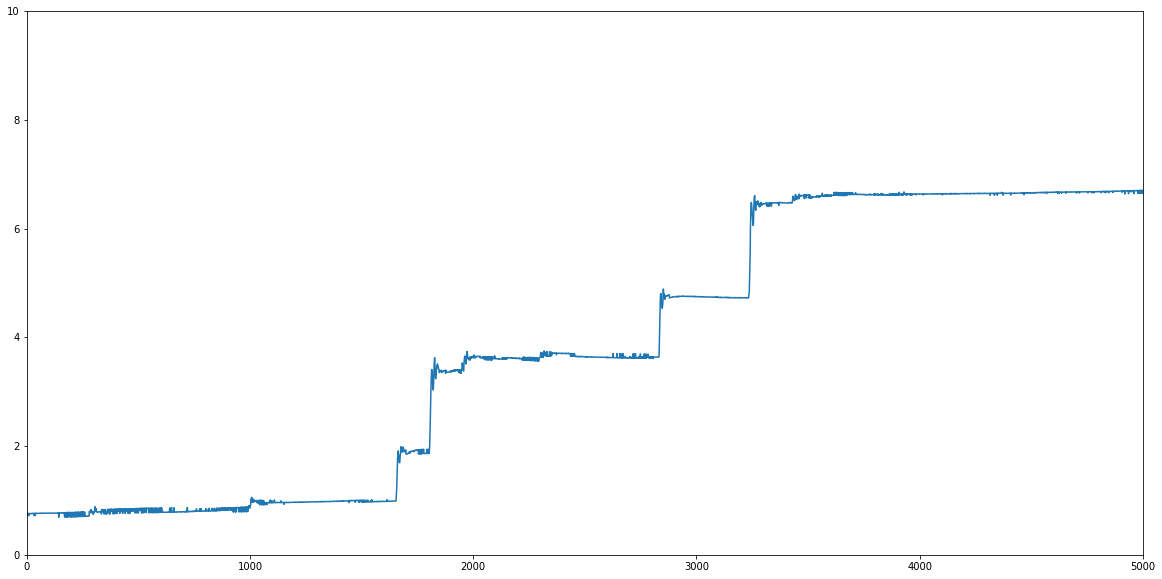

In [212]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.xlim(0,5000)
plt.ylim(0,10)
plt.plot(data['cumulative_direction'])

In [108]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])

    return right, left

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

In [173]:
flow_to_right, flow_to_left = divide_data_by_flow_direction(data)

In [174]:
C0, C01, C1, C2, C3, C5, C7, C10 = divide_data_by_contrast(flow_to_left)

In [222]:
len(C01)

8141

In [179]:
# remove timestamp and extras
# keep x, y, heading, cumulative, timestamp
new = C10.drop(columns = ['beat_freq', 'beat_amp','tail_move?','contrast_level','flow_direction'])


# resetting index
new = pd.DataFrame(new)
new = new.set_index('timestamp').reset_index()


# remove time points where there was an angle change of more than pi from one frame to another
for row in range(len(new)-1):
    heading = new.iloc[row,3]
    next_heading = new.iloc[row+1,3]
    if np.abs(next_heading-heading) >= np.pi:
        new.iloc[row+1,3] = new.iloc[row,3]

In [213]:
new

,timestamp,X_coord,Y_coord,heading_direction,cumulative_direction
0,425,620.6542,892.0280,0.719849,0.719849
1,429,620.7598,891.9224,0.757939,0.757939
2,432,620.6842,891.9794,0.758545,0.758544
3,438,620.7333,891.9125,0.759385,0.759385
4,442,620.7429,891.8914,0.759881,0.759881
...,...,...,...,...,...
8223,78,573.6365,851.9205,3.075716,9.358902
8224,81,573.5010,851.8788,3.073740,9.356926
8225,85,573.6244,851.9489,3.077491,9.360676
8226,88,573.3917,851.9295,3.077226,9.360412


In [178]:
new.iloc[0,3]

0.719849053012812

In [155]:
def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?','contrast_level','flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for row in range(len(new)-1):
        heading = new.iloc[row,3]
        next_heading = new.iloc[row+1,3]
        if np.abs(next_heading-heading) >= np.pi:
            new.iloc[row+1,3] = new.iloc[row,3]


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and adjusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']*10

    return interp

In [194]:
LC10 = omr_preprocess(C10)
LC10

,timestamp,X_coord,Y_coord,heading_direction,cumulative_direction,distance_pts
0,10,620.6542,892.0280,0.719849,0.000000,0.000000
1,20,620.7598,891.9224,0.757939,0.038090,0.149341
2,30,620.6842,891.9794,0.758545,0.038695,0.094680
3,40,620.7333,891.9125,0.759385,0.039536,0.082984
4,50,620.7429,891.8914,0.759881,0.040032,0.023181
...,...,...,...,...,...,...
2995,29960,552.7538,940.3565,4.753433,4.033584,0.122328
2996,29970,552.6868,940.1309,4.750253,4.030404,0.235339
2997,29980,552.6833,940.3055,4.749702,4.029853,0.174635
2998,29990,552.6880,940.2466,4.750079,4.030230,0.059087


In [ ]:
LC10['']

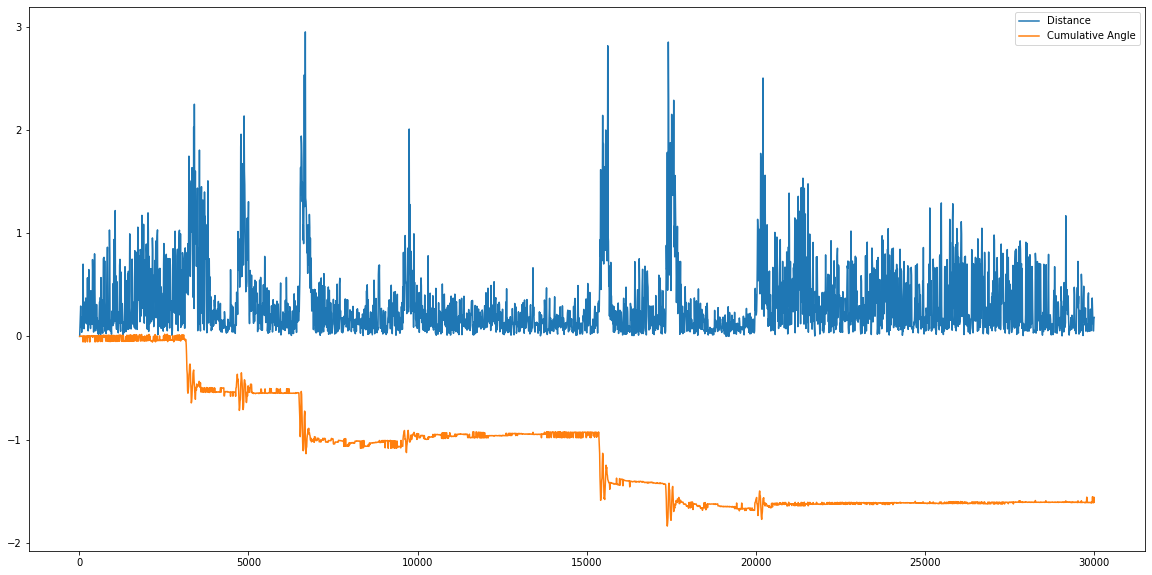

In [172]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(prep_LC1['timestamp'],prep_LC1['distance_pts'],label='Distance')
ax.plot(prep_LC1['timestamp'],prep_LC1['cumulative_direction'],label='Cumulative Angle')
# ax.set_ylim(20,20.3)
# ax.set_xlim(15000,20000)
plt.legend()
plt.show()

In [200]:
from scipy.ndimage import gaussian_filter1d
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 1)
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 4)

import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = rng.standard_normal(101).cumsum()

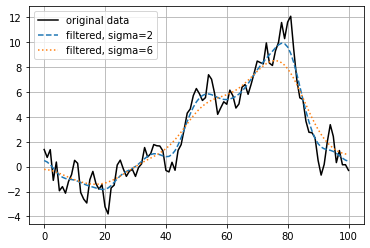

In [204]:
y3 = gaussian_filter1d(x, 3)
y6 = gaussian_filter1d(x, 6)
plt.plot(x, 'k', label='original data')
plt.plot(y3, '--', label='filtered, sigma=2')
plt.plot(y6, ':', label='filtered, sigma=6')
plt.legend()
plt.grid()
plt.show()